# **Custom Cloud Mask Performance Evaluation in the Alps**

* **Products used: s2_l2a**
* This notebook is designated to run in the Colab environment
* 07-12-2022

<br>

## **Background**

The cloud mask provided in the **SCL band** of Sentinel-2 product in Data Cube shows limited performance in distinguishing cloud objects in the presence of snow as well as other bright features. Besides, the classificaton accuracy for other categories such as water and snow are also limited. Hence, here we attempt to compute a custom cloud mask by integrating statistical information of **Sentinel-2** scenes using proposed NDCI (Normalized Difference Cloud Index). This notebook serves as an example for the accuracy assessment. The original script was written with **xarray** in **Open Data Cube (ODC)** environment. It is converted to **gdal** and the scenes are downloaded in the **Google Earth Engine (GEE)**.

<br>

***

<br>

## **Description**

The workflow can be divided into the following:

<br>

**1) Import scene for custom cloud mask generation and scl band acquisition**

**2) Develope GDAL function for the implementation of cloud mask outside of Open Data Cube**

**3) Import validation data (sampling points) generated from QGIS application**

**4) Accuracy assessment & Calculation of confusion matrix**

***

### Set Up Environment

Install and import libraries required for the following computation. In order to compute the cloud mask, we need the geospatial library **xarray, rasterio, and geopandas** for data manipulation and visualization. The cloud mask itself is mostly done using **gdal**. As the cloud mask is mainly based on dynamic statistical thresholds, the values are computed using **scipy**.

We will install rasterio and geopandas in colab environment.

In [ ]:
! pip install rasterio

In [ ]:
! pip install geopandas

### Import Libraries

In [4]:
import scipy
import sys
import numpy as np
from scipy import ndimage
from osgeo import gdal
from osgeo.gdalconst import *
import os
import glob
import rasterio as rio
from osgeo import gdal_array
import xarray as xr
import geopandas as gpd
from datetime import datetime
import warnings; warnings.simplefilter('ignore')
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.pyplot as plt
import pandas as pd
import holoviews as hv
from holoviews import dim, opts
from matplotlib import cm
from matplotlib import colors

%matplotlib inline

In [5]:
# import specific libraries for histogram-based analysis
from scipy.stats import skew
from scipy import stats
from scipy.stats import norm, kurtosis
from scipy.signal import find_peaks
from scipy.signal import argrelmin

# import subprocess to run gdal command line in Python
from subprocess import Popen, PIPE

Connect to Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Check files in the current directory, the following files are needed:

* Geotiff files of the Sentinel-2 scenes for evaluation
* SCL band of the scenes
* Shapefile for cloud objects **(For validation)**
* Shapefile for non-cloud objects - water bodies, land features **(For validation)**

We can list the files in the directory.

In [ ]:
print(os.popen('ls /content/drive/MyDrive/Alps').read())

alps_s2_20190320.tif
cm_class_s2_20190320.tif
cm_s2_20190320.tif
sscm_s2_20190320.tif



Change current working directory.

In [7]:
%cd /content/drive/MyDrive/Alps

/content/drive/MyDrive/Alps


In [8]:
! pwd

/content/drive/MyDrive/Alps


Using the function **run()**, we can run gdal command line to check info for **alps_s2_20190320.tif**. Apparently, it has **7 bands** with **EPSG 32633** and data type **UInt16**.

In [ ]:
run("gdalinfo alps_s2_20190320.tif")

----------------------------------------
running: gdalinfo alps_s2_20190320.tif
Output:  Driver: GTiff/GeoTIFF
Files: alps_s2_20190320.tif
Size is 4399, 797
Coordinate System is:
PROJCS["WGS 84 / UTM zone 33N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",15],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32633"]]
Origin = (293640.000000000000000,5239140.0000000000000

## Data Import

In [51]:
# Open the new tiff file

filepath = r"/content/drive/MyDrive/Alps/alps_s2_20190320.tif"

# Open the file:
dataset = gdal.Open(filepath)
dataset

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7ff00854ff00> >

We can read the first band as numpy array for further visualization.

In [ ]:
dataset.GetRasterBand(1).ReadAsArray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

## First Visualization
* First Band

Plotting the first band with imshow().

Text(0.5, 1.0, 'First Band')

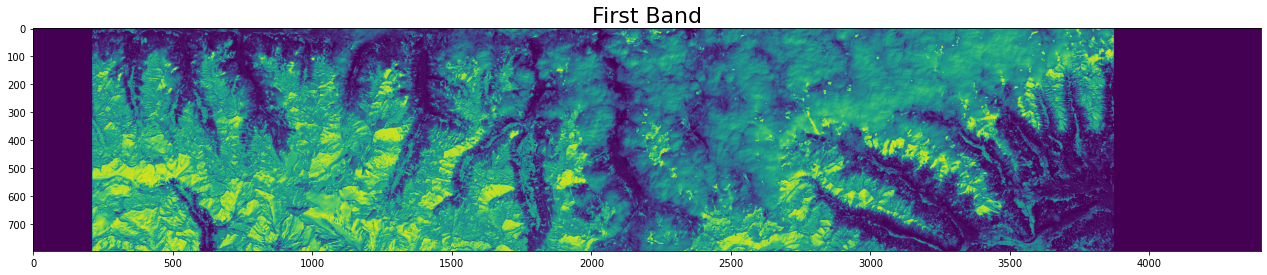

In [ ]:
plt.figure(figsize = (22,10))
plt.imshow(dataset.GetRasterBand(1).ReadAsArray())
plt.title("First Band", fontsize=22)

* Second Band

Text(0.5, 1.0, 'Second Band')

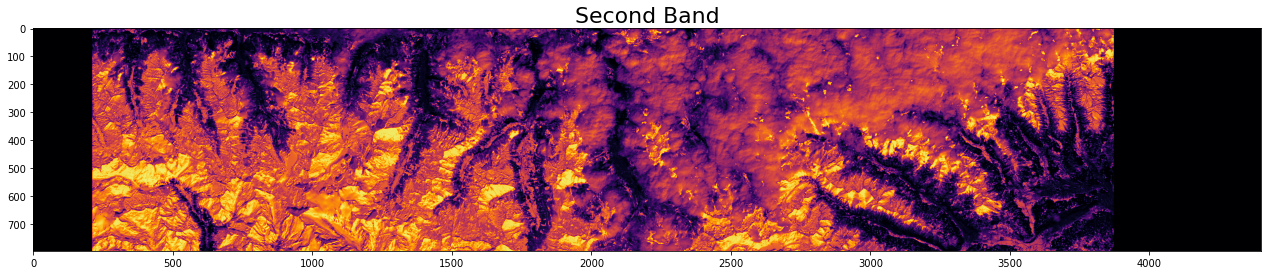

In [ ]:
plt.figure(figsize = (22,10))
plt.imshow(dataset.GetRasterBand(2).ReadAsArray(), cmap="inferno")
plt.title("Second Band", fontsize=22)

## Function Application

Using **ssmask()**, we can create a classification for **cloud (1)**, **snow (12)**, **water (11)**, **land (0)**, and **missing values (99)**. Let's run the function using our gdal dataset.

In [52]:
newMask = ssmask(dataset)

Start building arrays
Blue Band:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
01/10 Start snow classification
02/10 Initialize snow map array
03/10 Calculating Spectral Indices
04/10 Scene classification
Condition 3


Shape for the ouput.

In [ ]:
newMask.shape

(797, 4399)

We can also check what values are included in the mask.

In [ ]:
np.unique(newMask)

array([ 0.,  1., 11., 12., 99.])

### **Histogram**

In order to better understand the distribution of different categories among all pixels, let's plot a histogram.

(array([[  0.,   0.,   0., ...,   0.,   0., 797.],
        [  0.,   0.,   0., ...,   0.,   0., 797.],
        [  0.,   0.,   0., ...,   0.,   0., 797.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0., 797.],
        [  0.,   0.,   0., ...,   0.,   0., 797.],
        [  0.,   0.,   0., ...,   0.,   0., 797.]]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <a list of 4399 Lists of Patches objects>)

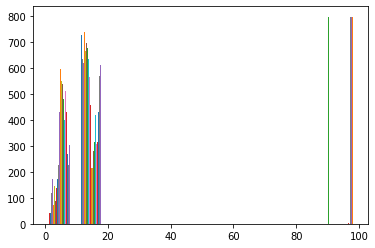

In [ ]:
plt.hist(newMask)

## Classification Results

After running the function, we can check the classification by plotting the result.

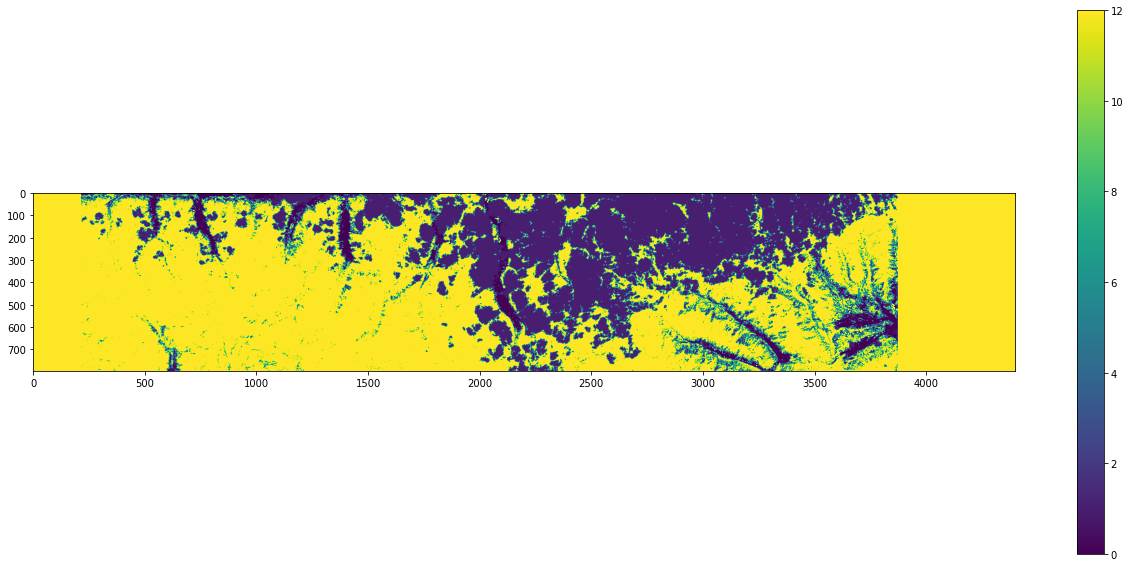

In [ ]:
plt.figure(figsize=(22,10))
plt.imshow(newMask, vmax=12)
plt.colorbar()

We can also visualize different categories in the subplots.

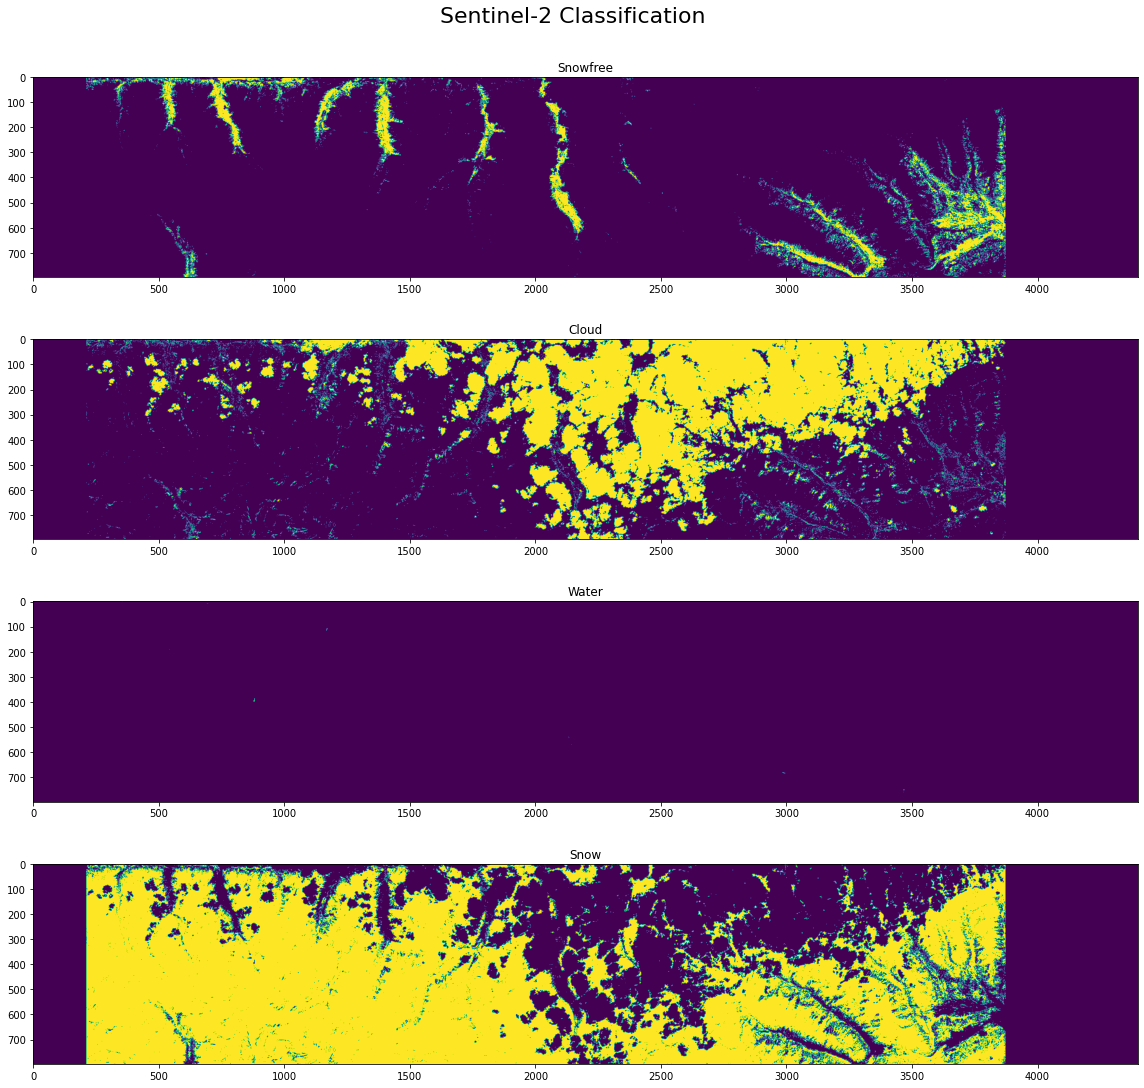

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(16,16))

ax1.imshow(newMask==0)
ax1.set_title('Snowfree')

ax2.imshow(newMask==1)
ax2.set_title('Cloud')

ax3.imshow(newMask==11)
ax3.set_title('Water')

ax4.imshow(newMask==12)
ax4.set_title('Snow')

plt.suptitle("Sentinel-2 Classification", fontsize=22)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Check Subregions

In order to better check the performance, we will subset the region for plotting.

Text(0.5, 1.0, 'S2 Imagery')

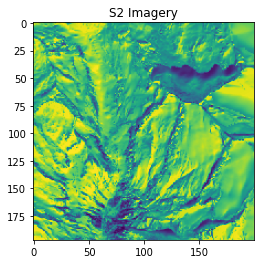

In [ ]:
plt.imshow(dataset.GetRasterBand(1).ReadAsArray()[600:800,800:1000])
plt.title("S2 Imagery")

Text(0.5, 1.0, 'Snow')

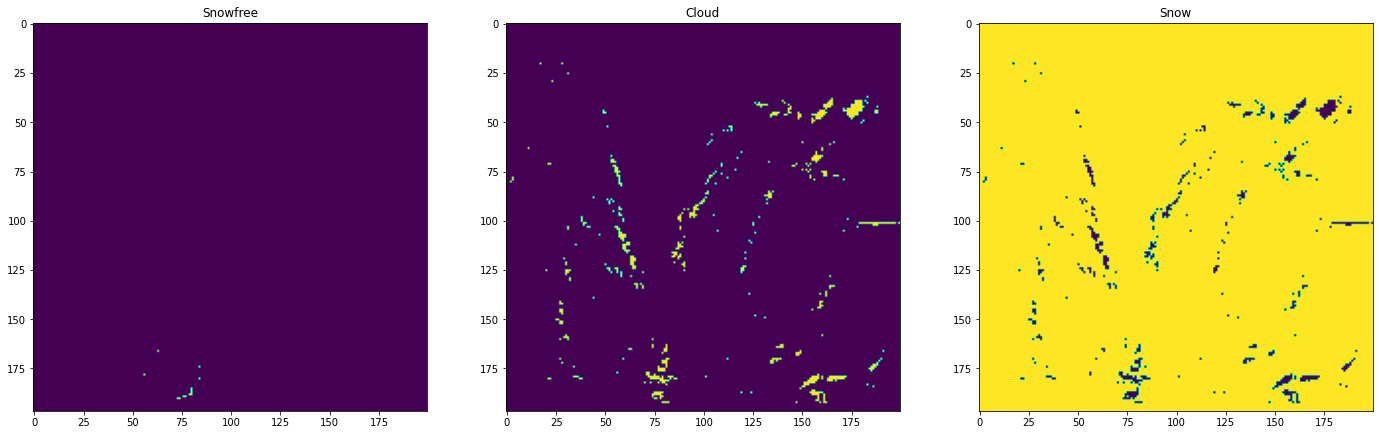

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(24,8))

ax1.imshow(newMask[600:800,800:1000]==0)
ax1.set_title('Snowfree')

ax2.imshow(newMask[600:800,800:1000]==1)
ax2.set_title('Cloud')

ax3.imshow(newMask[600:800,800:1000]==12)
ax3.set_title('Snow')

* ## SCL Band

After having an initial check for the cloud mask performance, we can visualize the SCL band for our first comparison.

In [ ]:
! ls

alps_s2_20190320.tif	  cm_s2_20190320.tif
cm_class_s2_20190320.tif  sscm_s2_20190320.tif


### Checking Info

run() use subprocess to run gdal command line in Python.

In [ ]:
run("gdalinfo cm_class_s2_20190320.tif")

----------------------------------------
running: gdalinfo cm_class_s2_20190320.tif
Output:  Driver: GTiff/GeoTIFF
Files: cm_class_s2_20190320.tif
Size is 6438, 694
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (12.281407238368452,47.273392669147761)
Pixel Size = (0.000269494585236,-0.000269494585236)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=LZW
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  12.2814072,  47.2733927) ( 12d16'53.07"E, 47d16'24.21"N)
Lower Left  (  12.2814072,  47.0863634) ( 12d16'53.07"E, 47d 5'10.91"N)
Upper Right (  14.0164134,  47.2733927) ( 14d 0'59.09"E, 47d16'24.21"N)
Lower Right (  14.0164134,  47.0863634) ( 14d 0'59.09"E, 47d 5'10.91"N)
Center      (  13.1489103,  47.1798780) ( 13d 8'56.08

In [ ]:
scl_path = r"/content/drive/MyDrive/Alps/cm_class_s2_20190320.tif"

# Import the original cloud mask
scl_ds = rio.open(scl_path)

# Convert dataset into a 2D numpy array
scl_mat = np.zeros(scl_ds.shape, dtype=rio.float32)
scl_mat = scl_ds.read(1)

# Matrix value
scl_mat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

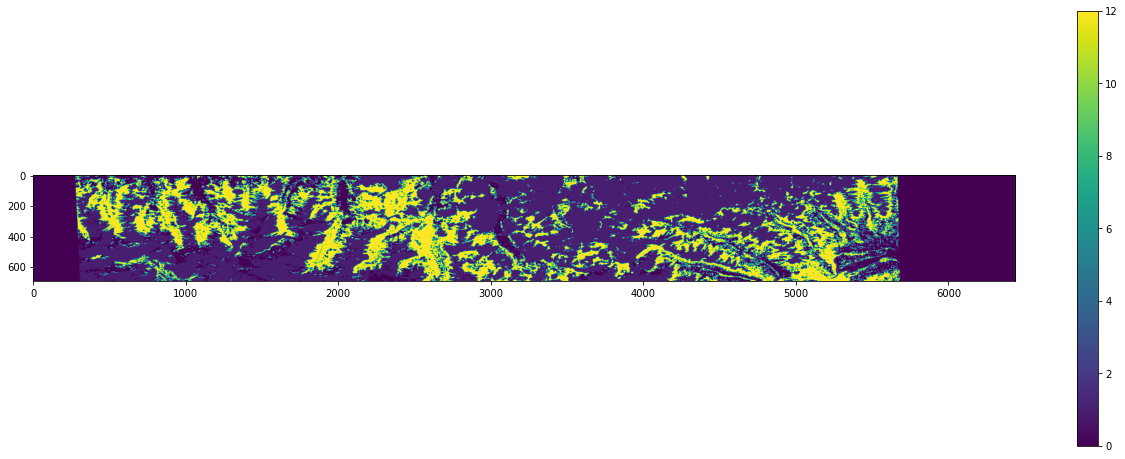

In [ ]:
plt.figure(figsize=(22,8))
plt.imshow(scl_mat)
plt.colorbar()

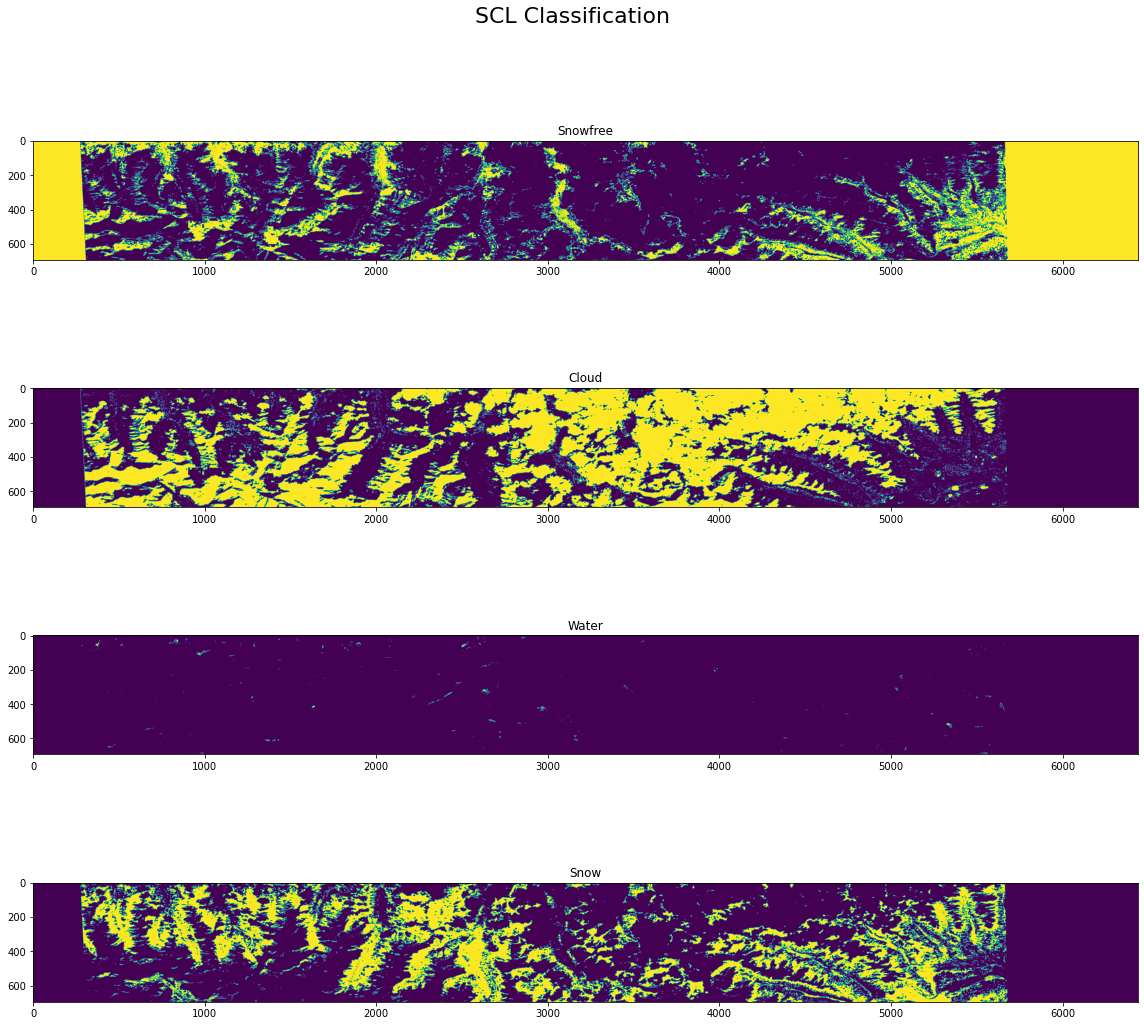

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(16,16))

ax1.imshow(scl_mat==0)
ax1.set_title('Snowfree')

ax2.imshow(scl_mat==1)
ax2.set_title('Cloud')

ax3.imshow(scl_mat==11)
ax3.set_title('Water')

ax4.imshow(scl_mat==12)
ax4.set_title('Snow')

plt.suptitle("SCL Classification", fontsize=22)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Text(0.5, 1.0, 'Snow')

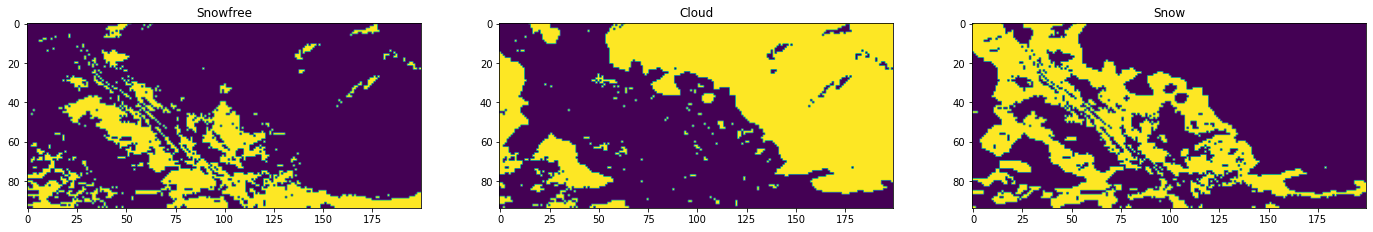

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(24,8))

ax1.imshow(scl_mat[600:800,800:1000]==0)
ax1.set_title('Snowfree')

ax2.imshow(scl_mat[600:800,800:1000]==1)
ax2.set_title('Cloud')

ax3.imshow(scl_mat[600:800,800:1000]==12)
ax3.set_title('Snow')

Apparently, there seem to be a significant differences between SCL results and the custom mask. It will be further examined using the vaildation data. To do so, we need to export the computed raster and sample points in QGIS.

## Output Export

Export mask to tiff file for accuracy assessment.

In [63]:
cm_path = r"/content/drive/MyDrive/Alps/cm_class_s2_20190320.tif"
out_path = r"/content/drive/MyDrive/Alps/sscm_s2_20190320.tif"

with rio.open(cm_path) as src:
    ras_data = src.read()
    ras_meta = src.profile

# make any necessary changes to raster properties, e.g.:
ras_meta['dtype'] = "int32"
ras_meta['nodata'] = -99

with rio.open(out_path, 'w', **ras_meta) as dst:
  dst.write(newMask, 1)

Check info for output.

In [60]:
run("gdalinfo sscm_s2_20190320.tif")

----------------------------------------
running: gdalinfo sscm_s2_20190320.tif
Output:  Driver: GTiff/GeoTIFF
Files: sscm_s2_20190320.tif
Size is 6438, 694
Coordinate System is:
PROJCS["WGS 84 / UTM zone 33N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",15],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32633"]]
Origin = (12.281407238368452,47.273392669147761)
Pixel

## **Accuracy Assessment**

Function generate_random() and accuracy_assessment() is written to generate random points in vector polygons, extract raster values and compute accuracy for different raster results.

In [9]:
import geopandas as gpd

In [97]:
run("gdal_translate -a_nodata -9999 sscm_s2_20190320.tif sscm_s2_20190320_edit.tif") 

run("gdal_translate -a_nodata -9999 cm_class_s2_20190320.tif cm_class_s2_20190320_edit.tif") 

----------------------------------------
running: gdal_translate -a_nodata -9999 sscm_s2_20190320.tif sscm_s2_20190320_edit.tif
Output:  Input file size is 6438, 694
0...10...20...30...40...50...60...70...80...90...100 - done.

----------------------------------------
running: gdal_translate -a_nodata 100 cm_class_s2_20190320.tif cm_class_s2_20190320_edit.tif
Output:  Input file size is 6438, 694
0...10...20...30...40...50...60...70...80...90...100 - done.



## Snow Class

In [64]:
df_snow = accuracy_assessment(truth_shp="snow_20190320_4326.shp", cm_tif="sscm_s2_20190320.tif", scl_tif="cm_class_s2_20190320.tif", truth_class=12)
df_snow.head()

,CM,SCL,truth,lon,lat
0,12,1,12,12.376907,47.184858
1,12,1,12,12.381351,47.175263
2,99,12,12,12.363580,47.196724
3,12,1,12,12.389237,47.179229
4,12,1,12,12.397799,47.167557


In [25]:
len(df_snow)

29472

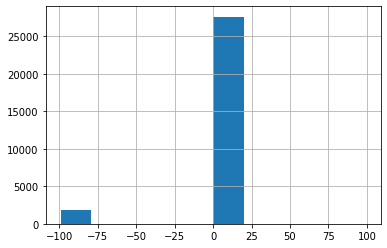

In [65]:
df_snow.CM.hist()

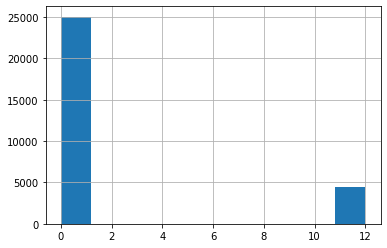

In [66]:
df_snow.SCL.hist()

In [67]:
pd.crosstab(df_snow['truth'], df_snow['SCL'], rownames=['Ground Truth'], colnames=['SCL Classification'])

SCL Classification,0,1,12
Ground Truth,,,
12,3261,21765,4446


In [68]:
pd.crosstab(df_snow['truth'], df_snow['CM'], rownames=['Ground Truth'], colnames=['CM Classification'])

CM Classification,-99,0,1,12,99
Ground Truth,,,,,
12,1844,149,1990,25484,5


## Land Class

In [83]:
df_land = accuracy_assessment("land_20190320_4326.shp","sscm_s2_20190320.tif","cm_class_s2_20190320.tif",0)
df_land.tail()

,CM,SCL,truth,lon,lat
25564,1,0,0,13.112203,47.229632
25565,1,0,0,13.109899,47.229605
25566,1,0,0,13.111434,47.231693
25567,1,0,0,13.107459,47.232093
25568,0,0,0,13.106307,47.228597


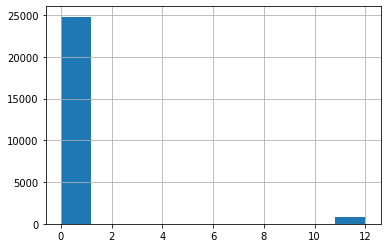

In [72]:
df_land.SCL.hist()

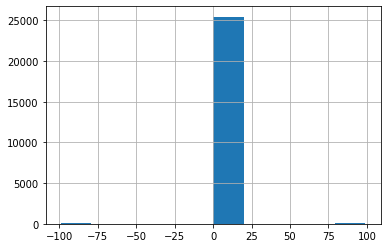

In [73]:
df_land.CM.hist()

In [75]:
pd.crosstab(df_land['truth'], df_land['SCL'], rownames=['Ground Truth'], colnames=['SCL Classification'])

SCL Classification,0,1,11,12
Ground Truth,,,,
0,24123,669,290,487


In [76]:
pd.crosstab(df_land['truth'], df_land['CM'], rownames=['Ground Truth'], colnames=['CM Classification'])

CM Classification,-99,0,1,12,99
Ground Truth,,,,,
0,46,9191,2663,13600,69


## Cloud Class

In [78]:
df_cloud = accuracy_assessment("cloud_20190320_4326.shp","sscm_s2_20190320.tif","cm_class_s2_20190320.tif",1)
df_cloud.head()

,CM,SCL,truth,lon,lat
0,1,1,1,12.392270,47.249330
1,1,1,1,12.392049,47.248170
2,1,1,1,12.396028,47.247522
3,1,1,1,12.391014,47.246928
4,12,1,1,12.387611,47.248122


In [79]:
pd.crosstab(df_cloud['truth'], df_cloud['SCL'], rownames=['Ground Truth'], colnames=['SCL Classification'])

SCL Classification,0,1,12
Ground Truth,,,
1,4176,25624,23


In [80]:
pd.crosstab(df_cloud['truth'], df_land['CM'], rownames=['Ground Truth'], colnames=['CM Classification'])

CM Classification,-99,0,1,12,99
Ground Truth,,,,,
1,46,9191,2663,13600,69


## Combining Class - Confusion Matrix

In [102]:
frames = [df_snow,df_cloud,df_land]
df = pd.concat(frames)
pd.crosstab(df['truth'], df['CM'], rownames=['Ground Truth'], colnames=['CM Classification'])

CM Classification,-99,0,1,12,99
Ground Truth,,,,,
0,39,9229,2630,13592,79
1,4171,7,19699,5946,0
12,1844,149,1990,25484,5


In [103]:
pd.crosstab(df['truth'], df['SCL'], rownames=['Ground Truth'], colnames=['SCL Classification'])

SCL Classification,0,1,11,12
Ground Truth,,,,
0,24086,687,302,494
1,4176,25624,0,23
12,3261,21765,0,4446


# Functions

In [39]:
def accuracy_assessment(truth_shp, cm_tif, scl_tif, truth_class):
  """
  Compute data frame for accuracy assessment using validation data (.shp) and two rasters (.tiff)
  truth_shp: path
    path to validation data
  cm_tif: path
    path to first raster
  cm_tif: path
    path to second raster
  truth_class: int
    class value for ground truth
  
  returns: pd.DataFrame
    Pandas data frame with columns: 
    CM: value from first raster for sample points
    SCL: value from second raster for sample points
    truth: values from ground truth for sample points
    lon: longitude for sample points
    lat: latitude for sample points
  """
  t = gpd.read_file(truth_shp)
  point = generate_random(30000, t.geometry)
  coords = []
  [coords.append(list(point[i].coords)[0]) for i in np.arange(len(point))]

  # Open the raster and store metadata
  src = rio.open(cm_tif)

  # Sample the raster at every point location and store values in DataFrame
  sample_cm = [int(x[0]) for x in src.sample(coords)]

  # Open the raster and store metadata
  scl = rio.open(scl_tif)

  # Sample the raster at every point location and store values in DataFrame
  sample_scl = [int(x[0]) for x in scl.sample(coords)]

  df = pd.DataFrame()

  df["CM"] = sample_cm
  df["SCL"] = sample_scl
  df["truth"] = [truth_class for i in coords]
  df = df.astype(int)
  
  df["lon"] = [i[0] for i in coords]
  df["lat"] = [i[1] for i in coords]
  
  df = df.replace(-9999, np.nan)
  #df = df.dropna(how="any")
  
  return df

In [12]:
import random
from shapely.geometry import Point

def generate_random(total_number, multipolygon):
  """
  Generate random sample points in polygons
  total_number: int
    number of sample points selected in all polygons in total (evenly distributed in each polygon)
    maximum 1 point every 30m*30m
  multipolygon: path
    path to shapefile for drawing sample points
  returns: list of tuples
    list of tuples for longitude and latitude of the sample points (same projection as input shp)
  """
    number = total_number/len(multipolygon)
    total_points = []
    for polygon in multipolygon:
      max_pts = abs(polygon.bounds[2] - polygon.bounds[0])*abs(polygon.bounds[1] - polygon.bounds[3])*(111319**2)/(30*30)
      max_pts = round(max_pts)
      points = []
      minx, miny, maxx, maxy = polygon.bounds
      while len(points) < number and len(points) < max_pts:
          pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
          if polygon.contains(pnt):
              points.append(pnt)
      total_points.append(points)
      flatten = [val for sublist in total_points for val in sublist]
    return flatten

In [13]:
def run(cmd, start = "ALL", end = "ALL"):
    """
    Run gdal command line in Python using subprocess and print output
    cmd: str
      string for command line input
    start: "ALL"/int
      Either print all output or subset output by indicating index for slicing (number of line)
    end: "ALL"/int
      Either print all output or subset output by indicating index for slicing (number of line)
    """
    print('-'*40)
    print('running:', cmd) # command input
    p = Popen(cmd, stderr=PIPE, stdout=PIPE, shell=True) # run commend in shell
    output, errors = p.communicate()
    output_str = output.decode("utf-8") # convert bytes info tro string 
    errors_str = errors.decode("utf-8")
    formatted_output = output_str.replace('\\n', '\n').replace('\\t', '\t') # reformat string for new lines
    if np.logical_and(start != "ALL", end != "ALL"):
      formatted_output_list = (formatted_output.rsplit('\n'))[start:end]
      formatted_output = '\n'.join(formatted_output_list)
    formatted_errors = errors_str.replace('\\n', '\n').replace('\\t', '\t')
    print("Output: ", formatted_output) # print output
    if p.returncode or errors: # check errors
        print('Something went wrong...')
    if p.returncode != 0: # check return code - 0: no error, 1: error occurs
        print("Errors: ", formatted_errors) # print error message if something goes wrong

In [14]:
def ssmask(S2_data):
    """
    Sentinel 2 classification of cloud mask.
    Description
    ----------
    Generating cloud classification used in Burkina Faso.
    Parameters
    ----------
    S2_data: osgeo.gdal.Dataset
        Landsat-8 dataset with blue, green, red, nir, swir, and thermal bands
    Returns
    -------
    CM_data: osgeo.gdal.Dataset
        dataset with binary cloud mask, where cloud == 1, clear == 0, water == 11, snow == 12
    """
    print("Start building arrays")
    t = np.float32
    
    # Read Bands
    blue = S2_data.GetRasterBand(1).ReadAsArray(0, 0, S2_data.RasterXSize, S2_data.RasterYSize)
    green = S2_data.GetRasterBand(2).ReadAsArray(0, 0, S2_data.RasterXSize, S2_data.RasterYSize)
    red = S2_data.GetRasterBand(3).ReadAsArray(0, 0, S2_data.RasterXSize, S2_data.RasterYSize)
    rededge3 = S2_data.GetRasterBand(4).ReadAsArray(0, 0, S2_data.RasterXSize, S2_data.RasterYSize)
    nir = S2_data.GetRasterBand(5).ReadAsArray(0, 0, S2_data.RasterXSize, S2_data.RasterYSize)
    vapour = S2_data.GetRasterBand(6).ReadAsArray(0, 0, S2_data.RasterXSize, S2_data.RasterYSize)
    swir1 = S2_data.GetRasterBand(7).ReadAsArray(0, 0, S2_data.RasterXSize, S2_data.RasterYSize)
    
    # Convert formats
    b = blue.astype(t)
    g = green.astype(t)
    e = rededge3.astype(t)
    r = red.astype(t)
    n = nir.astype(t)
    v = vapour.astype(t)
    s = swir1.astype(t)
    
    # Apply scale factors
    b = b * 0.00001
    g = g * 0.00001
    e = e * 0.00001
    r = r * 0.00001
    n = n * 0.00001
    s = s * 0.00001

    print("Blue Band: ", b)
    
    np.seterr(invalid='ignore')
    strength = 0.4
    
    print("01/10 Start snow classification")

    print("02/10 Initialize snow map array")
    CM = np.zeros(b.shape)

    print("03/10 Calculating Spectral Indices")
    ndsi = (g - s) / (g + s)
    ndvi = (n - r) / (n + r)
    ndci = (b - n) / (b + n)
    ndi = (g - n) / (g + n)    

    ###########SNOW MASK###############
    ndsi_exp = ndsi - (0.0652 * np.exp(1.8069 * ndvi))
    ndsi_div = ndsi - ((ndvi - 0.2883) / (-0.4828))
    ndwi = (g/10000 - n/10000)/(g/10000 + n/10000)
    ndsi_ci = ndsi - ndci
    
    ### Check for Water ###
    #CM[(e < 100) & (ndi > 0.7)] = 11
    #CM[(ndsi > 0) & (ndvi < 0.05) & (ndvi > -0.05) & (ndi > 0.7)] = 11
    CM[(ndsi > 0) & (ndi > 0.7) & (ndvi < 0.2)] = 11
        
    ### Check for Snow ###
    CM[(g > 4000) & (n > 4000) & (ndsi > 0.4)] = 12
    CM[(g > 4000) & (n > 4000) & (ndvi > 0.25) & (ndsi_exp >=0)] = 12
    CM[(g > 4000) & (n > 4000) & (ndvi > 0.2) & (ndvi < 0.25) & (ndsi_div > 0)] = 12
    CM[ndsi_ci > 0.5] = 12

    ndci_hist = ndci[(~np.isnan(ndci)) & (ndci != 0) & (CM != 11) & (CM != 12)]

    ##########################

    # Store statistics
    NDCI_min = np.quantile(ndci_hist,0.05) # minimum NDCI allowing 5% outliners
    NDCI_max = np.quantile(ndci_hist,0.95) # maximum NDCI allowing 5% outliners
    NDCI_std = np.std(ndci_hist) # NDCI standard deviation
    vapour_median = np.median(v[~np.isnan(v)]) # median for water vapour
    NDCI_skew = skew(ndci_hist) # NDCI skewness: how far is NDCI away from normal distribution
    NDCI_median = np.median(ndci_hist) # NDCI median
    NDCI_kur = kurtosis(ndci_hist) # NDCI kurtosis: depends on the shape of distribution
    
    # calculating the peak of NDCI histogram and detect number of peaks
    counts, bin_edges = np.histogram(ndci_hist) # get frequency count of every NDCI range groups
    peaks,_ = find_peaks(counts, prominence=len(ndci_hist)/50) # get all peaks (between increasing and decreasing counts)
    npeak = len(peaks.flatten()) # get the number of peaks
    
    print("04/10 Scene classification")
    
    # Classified Scene: All Clouds
    if NDCI_min >= -0.1:
        CM = np.zeros(b.shape)
        
    # Classified Scene: Mostly clouds
    elif NDCI_min < -0.1 and NDCI_min >= -0.3:
        if bin_edges[peaks[0]] < -0.3:
            thres = bin_edges[peaks[0]]
        else:
            thres = -0.3
        CM[(ndci > thres) & (CM != 11) & (CM != 12)] = 1 
    
    # Classified Scene: Mostly clouds
    
    # other condition for scene to be classify as mostly clouds: lower NDCI but histogram highly skewed towards high values
    # kurtosis values restricted to peak to be sharp for cloudy conditions
    # if clouds are dominant in scene, there should be only one peak in the histogram
    
    elif NDCI_min < -0.3 and NDCI_median > -0.35 and NDCI_kur > -1 and NDCI_skew < 0 and npeak == 1:
        print("Condition 3")
        if bin_edges[peaks[0]] < -0.3:
            thres = bin_edges[peaks[0]]
        else:
            thres = -0.3
        CM[(ndci > thres) & (CM != 11) & (CM != 12)] = 1
    
    # Classified Scene: Clear sky
    
    # either low NDCI for all pixels or low median with really sharp peak for sunny conditions
    
    elif NDCI_max < -0.3 or (NDCI_kur > 1.5 and NDCI_median < -0.4):
        print("Condition 4")
        print(v)
        CM[(ndci > -0.3) & (v > vapour_median*1.1) & (CM != 11) & (CM != 12)] = 1
    
    # Classified Scene: Partly clouds
    else:
        print("Condition 5")
        counts, bin_edges = np.histogram(ndci_hist, bins=30)
        if npeak <= 1:
            peak = np.argmax(counts)
            mode = (bin_edges[peak] + bin_edges[peak+1])/2 # check dominant NDCI value

            par = stats.percentileofscore(ndci_hist, mode) # get quantile for dominant NDCI value

            factor = 1 - NDCI_std # define fector to adjust NDCI threshold 
            # the more variant NDCI, the more conservative to define the end of NDCI cluster
            adj_factor = (100 - par)*(factor/50) # tune the value to make sure percentile lies within 0% and 100%
            refine = (par + adj_factor)/100
            NDCI_thres = np.quantile(ndci_hist,refine) # calculate the NDCI threshold

        else:
            min_indices = argrelmin(counts)[0]
            ind_min = np.argmin(counts[min_indices])
            ind_hist = min_indices[ind_min]
            NDCI_thres = (bin_edges[ind_hist] + (-0.4))/2
            strength = 0.5
        
        # default values false for neg: indicate negative strength
        neg = False
        
        # adjust strength depends on NDCI skewness (the proxy for cloud proportion)
        # to make sure consistent masking independent of weather condition
        if NDCI_skew > 1:
            strength = strength + 0.3
            if strength > 1:
                strength = 1 # make sure strength lies within 0 and 1
        elif NDCI_skew > 0 and NDCI_skew < 0.2: # less strength when there are few clouds
            strength = strength - 0.2
            if strength < 0:
                neg = True
                negative_adj = strength
                strength = 0
        elif NDCI_skew < -0.4: # increase strength when there are lots of clouds
            strength = strength + 0.3
            if strength > 1:
                strength = 1
                
        # apply strength to adjust the NDCI threshold
        if NDCI_thres <= 0:
            NDCI_thres_adjust = (NDCI_thres - 1) * strength * 2
            NDCI_thres_adjust = NDCI_thres_adjust + (strength * 2)
        else:
            NDCI_thres_adjust = (NDCI_thres + 1) * strength * -2
            NDCI_thres_adjust = NDCI_thres_adjust - (strength * -2)

        if neg == True:
            NDCI_thres_adjust = NDCI_thres_adjust + negative_adj/5 

        # use NDCI sknewness as the proxy for cloudyness of the scene
        # which is used for second condition depending on the water vapour value
        
        if NDCI_skew >= -0.5 and NDCI_skew < -0.3:
            CM[(ndci > NDCI_thres_adjust) & (v > np.quantile(v,0.45)) & (ndvi < 0.2) & (CM != 11) & (CM != 12)] = 1
            
        elif NDCI_skew < -0.5: # lower water vapour threshold for relatively cloudy condition
            CM[(ndci > NDCI_thres_adjust) & (v > np.quantile(v,0.3)) & (ndvi < 0.2) & (CM != 11) & (CM != 12)] = 1
 
        else: # higher water vapour threshold for relatively less cloudy condition
            CM[(ndci > NDCI_thres_adjust) & (v > np.quantile(v,0.5)) & (ndvi < 0.2) & (CM != 11) & (CM != 12)] = 1
        
    # sm_CM = ndimage.uniform_filter(CM, size=2, mode='nearest')
    # new_CM = (sm_CM == 1)
    # new_CM = new_CM.astype(int)
    
    CM[(np.isnan(b) == True) | (np.isnan(g) == True) | (np.isnan(s) == True) | (np.isnan(r) == True) | (np.isnan(n) == True)] = 99 # de-stripe
    CM[(b == 0) | (g == 0) | (s == 0) | (r == 0) | (n == 0)] = 99  # de-stripe

    return CM #new_CM